In [1]:
import shutil
from torch.utils.data import Dataset

import os,csv
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 45

# Other
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data process (No need to run)

In [41]:
for root, dirs, files in os.walk('.'):
    for item in dirs:
        if (item[0]!='.'):
            try:
                os.remove(os.path.join(item,'.DS_Store'))
            except:
                pass

In [39]:
folders = os.listdir('extracted_images/')
try:
    os.mkdir('mathsymbol')
except FileExistsError:
    pass
for subfolder in folders:
    subfolder_here = os.listdir(os.path.join('extracted_images',subfolder))     
    j = -1
    for image in subfolder_here:
        j+=1
        os.rename(os.path.join('extracted_images',subfolder,image), os.path.join('extracted_images',subfolder,subfolder+'_'+str(j)+'.jpg'))

In [42]:
folders = os.listdir('extracted_images')
with open('msb.csv', mode='w') as msb:
    msb_writer = csv.writer(msb, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    msb_writer.writerow(['Filename', 'Class Label'])
    i = -1
    for subfolder in folders:
        i += 1
        subfolder_here = os.listdir(os.path.join('extracted_images',subfolder))
        for image in subfolder_here:
            msb_writer.writerow([image,str(i)])

In [49]:
for subfolder in folders:
    subfolder_here = os.listdir(os.path.join('extracted_images',subfolder))     
    for image in subfolder_here:
        shutil.move(os.path.join('extracted_images',subfolder,image), os.path.join('mathsymbol',image) )

In [75]:
def get_label(row):
    return int(row[1])

In [78]:
f6 = open('msb.csv', encoding="utf-8")
reader6 = list(csv.reader(f6))
f6.close()
sorted(reader6[1:],key=get_label,reverse=True)[:5]

[['geq_299.jpg', '45'],
 ['geq_272.jpg', '45'],
 ['geq_514.jpg', '45'],
 ['geq_500.jpg', '45'],
 ['geq_266.jpg', '45']]

mathsymbol/!_1.jpg


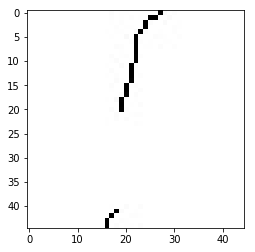

mathsymbol/(_10633.jpg


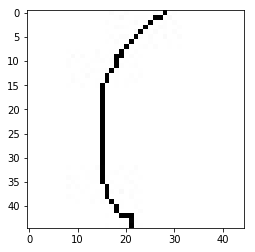

mathsymbol/)_12390.jpg


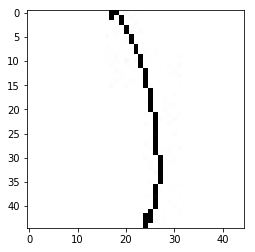

mathsymbol/+_2292.jpg


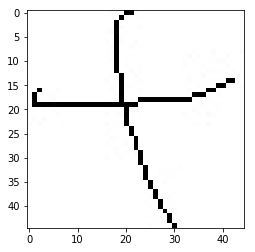

In [3]:
import glob
image_paths = sorted(glob.glob('mathsymbol/*.jpg'))
for i in (1,2000,18000,43284):
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()

# Loading data

In [6]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['Filename'].values
        self.y = df['Class Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [7]:
df_train = pd.read_csv('sample_data/sample_train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))
custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='sample_data/sample_train.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128, #### CHANGE IF YOU LIKE 128*0.9
                          shuffle=True,
                          num_workers=4)


valid_dataset = QuickdrawDataset(csv_path='sample_data/sample_valid.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=4)

test_dataset = QuickdrawDataset(csv_path='sample_data/sample_test.csv',
                                img_dir='mathsymbol/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=128,
                         shuffle=False,
                         num_workers=4)

Class distribution Train [ 117   46    8   23  103   98   49   15   12   56   10    2    3  185
  247   22 1383  110   22  171 1847   12  506  134  157  155   96    6
   32  114   35    3   27  160   77   75  146   45  810   19  743   21
  141  814   45   40]


In [8]:
#just check if data are loaded correctly
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 128
break minibatch for-loop


In [9]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [10]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def train(model, train_loader, test_loader):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader, device=DEVICE)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost


In [23]:
##########################
### MODEL
##########################

class ConvNet3(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet3, self).__init__()
        
        #### YOUR CODE
        self.conv0 = nn.Conv2d(1, 3, kernel_size=5, stride=1,padding=12)
        self.pool0  = nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv1 =  nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5,stride=1,padding=2)
        self.bn2   = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3,stride=1,padding=1)
        self.bn3   = nn.BatchNorm2d(384)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv4 = nn.Conv2d(384, 256, kernel_size=5,stride=1,padding=2)
        self.bn4   = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.conv5 = nn.Conv2d(256, 256, kernel_size=5,stride=1,padding=2)
        self.bn5   = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.linear1 = nn.Linear(256,4096)
        self.bnnl1   = nn.BatchNorm1d(4096)
        
        self.linear2 = nn.Linear(4096,4096)
        self.bnnl2   = nn.BatchNorm1d(4096)
        
        self.linear3 = nn.Linear(4096, num_classes)  

    def forward(self, x):

        #### YOUR CODE
        out = self.conv0(x)
        out = self.relu(out)
        out = self.pool0(out)
        #print(out.size())
        
        out = self.conv1(out)
        out = self.relu(out)
        out = self.pool1(out)
        #print(out.size())
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.dropout(out, p=0.2, training=self.training)
        out = self.relu(out)
        out = self.pool2(out)
        #print(out.size())
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = F.dropout(out, p=0.2, training=self.training)
        out = self.relu(out)
        out = self.pool3(out)
        #print(out.size())
        
        out = self.conv4(out)
        out = self.bn4(out)
        out = F.dropout(out, p=0.2, training=self.training)
        out = self.relu(out)
        out = self.pool4(out)
        #print(out.size())
        
        out = self.conv5(out)
        out = self.bn5(out)
        out = F.dropout(out, p=0.2, training=self.training)
        out = self.relu(out)
        out = self.pool5(out)
        #print(out.size())
        
        out = self.linear1(out.view(out.size(0),256))
        out = self.bnnl1(out)
        out = self.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        #print(out.size())
        
        out = self.linear2(out)
        out = self.bnnl2(out)
        out = self.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        #print(out.size())
        
        logits = self.linear3(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model3 = ConvNet3(NUM_CLASSES)
model3.to(DEVICE)

optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model3, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

torch.Size([128, 3, 32, 32])
torch.Size([128, 64, 16, 16])
torch.Size([128, 192, 8, 8])
torch.Size([128, 384, 4, 4])
torch.Size([128, 256, 2, 2])
torch.Size([128, 256, 1, 1])
torch.Size([128, 4096])
torch.Size([128, 4096])
Epoch: 001/020 | Batch 0000/0070 | Cost: 3.9272
torch.Size([128, 3, 32, 32])
torch.Size([128, 64, 16, 16])
torch.Size([128, 192, 8, 8])
torch.Size([128, 384, 4, 4])
torch.Size([128, 256, 2, 2])
torch.Size([128, 256, 1, 1])
torch.Size([128, 4096])
torch.Size([128, 4096])


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /Users/soumith/mc3build/conda-bld/pytorch_1549312653646/work/aten/src/THNN/generic/ClassNLLCriterion.c:93